In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
import cv2
import keras
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import Sequence
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [3]:
# image = cv2.imread("./dls-train-balanced/common_voice_bn_30614357.png")
# print(image.shape)
# BASE_DIR = "./drive/MyDrive/ml-project/dl-sprint"
n_epochs = 10
batch_size = 32
image_shape = (374, 500, 3)
base_dir = "./dls-train-balanced"

In [4]:
class DataGenerator(Sequence):

    def __init__(self, X, y, base_dir, batch_size, n_class, shuffle=False):
        self.X = X
        self.y = y
        self.n_class = n_class
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        assert len(self.X) == len(self.y)
        return int(np.floor(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        X_batch = self.X[index*self.batch_size : (index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size : (index+1)*self.batch_size]

        X = self.__data_generation(X_batch)
        y = keras.utils.to_categorical(y_batch, num_classes=self.n_class)
        return X, y

    def __data_generation(self, X_img):
        X = []
        for file in X_img:
            t = cv2.imread(f"{self.base_dir}/{file}", cv2.COLOR_BGR2RGB)
            X.append(t)
        return np.asarray(X)

In [3]:
#@title Model Creation
model = tensorflow.keras.applications.resnet50.ResNet50(weights=None, input_shape=image_shape)

model.build()
model.summary()

adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=adam)

102967424/102967424 [==============================] - 71s 1us/step


TypeError: Model.build() missing 1 required positional argument: 'input_shape'

In [6]:
df = pd.read_csv("./dls-train-balanced.csv")

X = df["imgname"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Dataset and Image Loaded")
print("X_train:", len(X_train), "\tX_test:",  len(X_test))
print("y_train:", len(y_train), "\ty_test:",  len(y_test))

Dataset and Image Loaded
X_train: 15304 	X_test: 3826
y_train: 15304 	y_test: 3826


In [7]:
#@title Model Training

train_gen = DataGenerator(X_train, y_train, base_dir=base_dir, n_class=2, batch_size=batch_size)
test_gen  = DataGenerator(X_test,  y_test,  base_dir=base_dir, n_class=2, batch_size=batch_size)

model.fit(train_gen, validation_data=test_gen, verbose=1)

478/478 [==============================] - 1871s 4s/step - loss: 5.4536 - accuracy: 0.9113 - val_loss: 0.2143 - val_accuracy: 0.9535


In [35]:
#@title Model Prediction
y_pred = model.predict(test_gen)
y_pred = np.round(y_pred)

print(y_pred)
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

119/119 [==============================] - 78s 658ms/step
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [37]:
y_pred_arg = np.argmax(y_pred, axis=1)
print(y_pred_arg)

[1 1 0 ... 0 1 0]


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1901
           1       0.98      0.92      0.95      1907

    accuracy                           0.95      3808
   macro avg       0.96      0.95      0.95      3808
weighted avg       0.96      0.95      0.95      3808



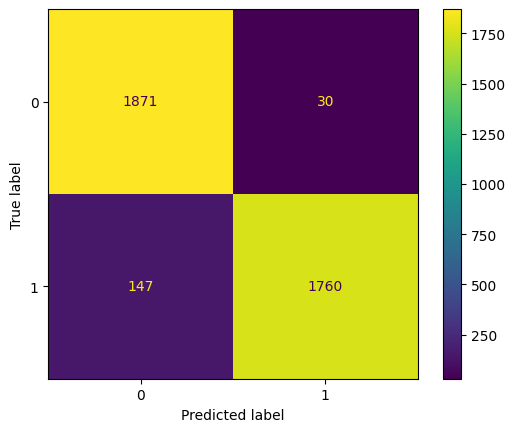

In [38]:
y_test = y_test[:3808]

report = classification_report(y_true=y_test, y_pred=y_pred_arg)
print(report)

conf_mat = confusion_matrix(y_test, y_pred_arg)
conf_dis = ConfusionMatrixDisplay(conf_mat)
conf_dis.plot()
plt.show()